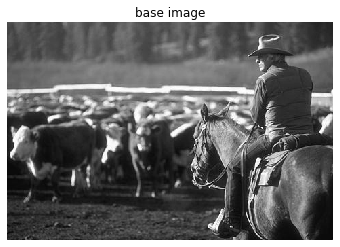

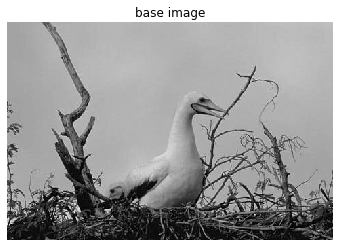

In [208]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

img_1 = mpimg.imread("data/ica/0/0-data_orig_img_nonlinear.png")
img_2 = mpimg.imread("data/ica/0/1-data_orig_img_nonlinear.png")

plt.imshow(img_1, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("base image")
plt.show()
plt.imshow(img_2, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("base image")
plt.show()

## Mixing
(all of this is coded in src.utils.mixing - and you can use run_mixing.sh script to achive similar results)

In [210]:
import skimage

from src.utils.measures import tucker_measure
from sklearn.preprocessing import minmax_scale

def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def relu(x):
    return np.maximum(x, 0)

def mlp(rs, Z, dim, fun):
    if fun == "sigmoid":
        f = sigmoid
    elif fun == "relu":
        f = relu
    elif fun == "tanh":
        f = np.tanh
    else:
        raise ValueError("Unknown activation function {}".format(fun))
    A = rs.normal(size=(dim, dim))
    b = rs.normal(dim)
    K1 = f(np.matmul(Z, A) + b)
    B = rs.normal(size=(dim, dim))
    b = rs.normal(dim)
    K2 = f(np.matmul(K1, B) + b)
    return K2

def flow_mixing(rs, Z, dim, times):
    for t in range(times):
        A = rs.normal(size=(dim, dim))
        hdim = dim // 2
        H = rs.normal(size=(hdim, hdim))

        u, s, vh = np.linalg.svd(A, full_matrices=True)
        Y = np.dot(Z, np.matmul(u, vh))

        i = t % 2
        j = 0 if i == 1 else 1

        X1 = Y[:, i::2]
        X2 = Y[:, j::2]

        Y1 = mlp(rs, X2, dim // 2, 'tanh') + X1
 

        Y2 = X2
        R = np.zeros(Y.shape)
        R[:, i::2] = Y1
        R[:, j::2] = Y2

        Z = minmax_scale(R)
    return Z

def nonlinear_mixing(array_of_pictures):
    tmp = array_of_pictures
    images = np.c_[[skimage.io.imread(_, as_gray=True).flatten() for _ in tmp]].T
    shape = skimage.io.imread(tmp[0], as_gray=True).shape
    
    batch_size, dim = images.shape
    rs = np.random.RandomState(seed=42)
    Z = images

    tm = 1
    while tm > .8:
        Z = flow_mixing(rs, Z, dim, 10)
        tm = tucker_measure(Z, images)
        print("Tucker for mix: " + str(tm))

    return Z * 255, shape, images

In [211]:
mixed, shape, orig = nonlinear_mixing(["data/ica/0/0-data_orig_img_nonlinear.png", "data/ica/0/1-data_orig_img_nonlinear.png" ])

Tucker for mix: 0.8813006171514361
Tucker for mix: 0.8380702877052155
Tucker for mix: 0.9910192598127632
Tucker for mix: 0.9774537491784487
Tucker for mix: 0.8547719558336992
Tucker for mix: 0.6768258884310315


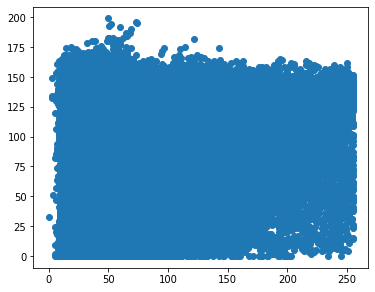

In [212]:
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(orig[:, 0], orig[:, 1])
plt.show()

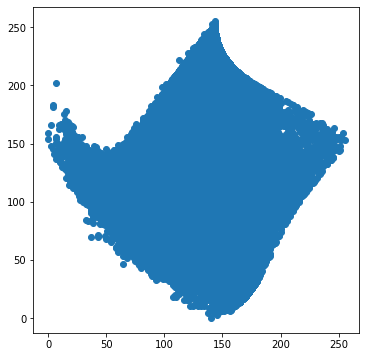

In [213]:
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(mixed[:, 0], mixed[:, 1])
plt.show()

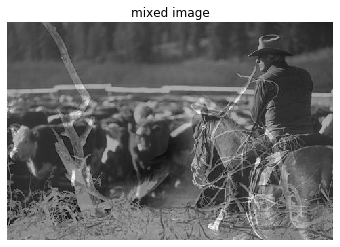

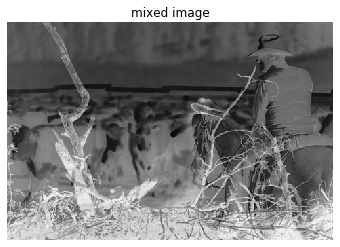

In [214]:
plt.imshow(mixed.T[0].reshape(321,481), cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("mixed image")
plt.show()
plt.imshow(mixed.T[1].reshape(321,481), cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("mixed image")
plt.show()

## Retriving data

In [ ]:
import glob

import numpy as np
import torch
from skimage import io
from torch.utils.data import Dataset


class Dataset(Dataset):
    """
    The dataset containing a flattened mix of pictures.
    """

    def __init__(self, mixed, orig):
        self.mix_dim = mixed.shape[1]
        self.orig_dim = orig.shape[1]
        self.mix = mixed
        self.orig = orig

    def __getitem__(self, index):
        mix = self.mix[index]
        orig = self.orig[index]
        return mix, orig

    def __len__(self):
        return len(self.mix)

In [ ]:
import os
import time

import numpy as np
import torch
from torch import optim
from torchvision.utils import save_image

from src.utils.helpers import to_img
from src.utils.measures import tucker_measure, spearman_metric_ilp

class IndependenceAETrainer(Trainer):
    def __init__(self, model, loss_class, dataloaders, cuda):
        self.model = model
        self.loss_class = loss_class
        self.train_dataloader, self.test_dataloader = dataloaders
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()

    @staticmethod
    def save_images_from_epoch(args, train_imgs, test_imgs, epoch):
        if (epoch + 1) % args["save_every"] == 0:
            if not args["save_raw"]:
                # specific for this dataset (selects only the first image)
                save_train = to_img(train_imgs[0:321 * 481].T.reshape(2, 1, 321, 481).cpu().data, args["normalize_img"])
                save_test = to_img(test_imgs[0:321 * 481].T.reshape(2, 1, 321, 481).cpu().data, args["normalize_img"])
                save_image(save_train,
                           os.path.join(os.path.join(args["folder"], 'images'), 'train_image_{}.png'.format(epoch)))
                save_image(save_test,
                           os.path.join(os.path.join(args["folder"], 'images'), 'test_image_{}.png'.format(epoch)))
            else:
                save_train = train_imgs.cpu().data
                save_test = test_imgs.cpu().data
                path_train = os.path.join(os.path.join(args["folder"], 'images'), 'train_{}.npy'.format(epoch))
                path_test = os.path.join(os.path.join(args["folder"], 'images'), 'test_{}.npy'.format(epoch))
                np.save(path_train, save_train)
                np.save(path_test, save_test)

    def report(self, epoch, epoch_time, loss_dict):
        report_string = '====> Epoch: {} [Time: {:.2f}s] '.format(epoch, epoch_time)
        for key, value in loss_dict.items():
            report_string += '[{}:{:.4f}]. '.format(key, value)
        print(report_string)
        
    def train(self, args):
        num_epochs = args["num_epochs"]
        lr = args["lr"]
        optimizer = optim.Adam(self.model.parameters(), lr)

        print("Beginning training...")
        for epoch in range(num_epochs):
            self.model.train()
            train_loss, train_sprm, train_tucker = 0, 0, 0

            start = time.time()

            images_to_save = []

            for batch_idx, (data, orig) in enumerate(self.train_dataloader):
                if args["cuda"]:
                    data = data.cuda()
                    orig = orig.cuda()
                optimizer.zero_grad()
                loss, recon, encoded = self.calculate_loss(data)

                images_to_save.extend(encoded)

                loss.backward()
                train_loss += loss.data
                train_tucker += self.calculate_tucker(encoded, orig)
                train_sprm += self.calculate_spearman(encoded, orig)
                optimizer.step()
            end = time.time()

            recon = torch.stack(images_to_save, dim=0)

            self.model.eval()
            test_loss, test_sprm, test_tucker = 0, 0, 0

            images_to_save = []

            for batch_idx, (data, t_orig) in enumerate(self.test_dataloader):
                if args["cuda"]:
                    data = data.cuda()
                loss, t_recon, t_encoded = self.calculate_loss(data)

                images_to_save.extend(t_encoded)

                if epoch == num_epochs - 1 and args["save_raw"]:
                    save_test = t_encoded.cpu().data
                    path_test = os.path.join(os.path.join(args["folder"], 'images'),
                                             'icatest_{}_{}.npy'.format(batch_idx, epoch))
                    np.save(path_test, save_test)
                test_loss += loss.data
                test_tucker += self.calculate_tucker(t_encoded, t_orig)
                test_sprm += self.calculate_spearman(t_encoded, t_orig)

            t_recon = torch.stack(images_to_save, dim=0)

            epoch_time = end - start
            loss_dict = self.get_loss_dict(
                train_loss,
                test_loss,
                train_tucker,
                test_tucker,
                train_sprm,
                test_sprm
            )
            self.report(epoch, epoch_time, loss_dict)
            self.save_images_from_epoch(args, recon, t_recon, epoch)

        state = self.get_state_dict(epoch, optimizer, loss_dict)
        torch.save(state, os.path.join(args["folder"], "model.th".format(epoch)))
        print("Training complete")

    def calculate_tucker(self, x, y):
        return tucker_measure(x.detach().numpy(), y.detach().numpy())

    def calculate_spearman(self, x, y):
        return spearman_metric_ilp(x.detach().numpy(), y.detach().numpy())

    def get_state_dict(self, epoch, optimizer, loss_dict):
        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        state.update(loss_dict)
        return state

    def get_loss_dict(self, train_loss, test_loss, train_tucker, test_tucker, train_sprm, test_sprm):
        div_train, div_test = len(self.train_dataloader), len(self.test_dataloader)

        return {
            'rec_loss': train_loss / div_train,
            'rec_loss_test': test_loss / div_test,
            'train_tucker': train_tucker / div_train,
            'test_tucker': test_tucker / div_test,
            'train_sprm': 1 - train_sprm / div_train,
            'test_sprm': 1 - test_sprm / div_test,
        }

    def calculate_loss(self, img):
        recon, encoded = self.model(img.float())
        loss = self.loss_class.loss(recon, img.float(), z=encoded)
        return loss, recon, encoded


In [ ]:
from torch.utils.data import DataLoader

from src.data_handling.datasets import FlattenedPicturesDataset
from src.decoders.decoder_provider import DecoderProvider
from src.encoders.encoder_provider import EncoderProvider
from src.models.loss_functions import *
from src.models.models import *


class TrainerBuilder:
    @staticmethod
    def get_trainer(args):
        loss = TrainerBuilder.__get_loss(args)
        dataloaders = TrainerBuilder.__get_dataloaders(args)
        trainer = TrainerBuilder.__get_trainer(args, loss, dataloaders)
        return trainer

    @staticmethod
    def __get_trainer(args, loss, dataloaders):
        encoder = EncoderProvider.get_encoder(args["latent_dim"])
        decoder = DecoderProvider.get_decoder(args["latent_dim"], args["normalize_img"])

        model = Autoencoder(encoder, decoder)
        return IndependenceAETrainer(model, loss, dataloaders, args["cuda"])

    @staticmethod
    def __get_loss(args):
        reg_loss = ReconstructionLoss.get_rec_loss(args["rec_loss"])
        ind_loss = WeightedICALossFunction(args["power"], args["number_of_gausses"], cuda=args["cuda"])
        return JoinedLoss(ind_loss, reg_loss, args["beta"])

    @staticmethod
    def __get_dataloaders(args):
        tmp = Dataset(args["mixes"], args["orig"])
        train_dataloader = DataLoader(tmp, batch_size=args["batch_size"], shuffle=True)
        test_dataloader = DataLoader(tmp, batch_size=args["batch_size"])
        return train_dataloader, test_dataloader


In [223]:
    trainer = TrainerBuilder.get_trainer({
                                         "latent_dim":2, 
                                         "normalize_img": True, 
                                         "cuda": False, 
                                         "rec_loss": "mse",
                                         "power": 0, 
                                         "number_of_gausses": 10, 
                                         "beta":100, 
                                         "mixes": mixed, 
                                         "orig": orig, 
                                         "batch_size": 256
    })
    
    trainer.train({
                   "num_epochs":6, 
                   "lr": 1e-3, 
                   "cuda": False, 
                   "save_every": 1, 
                   "save_raw": False, 
                   "folder":"./results", 
                   "normalize_img": True
                  })

Beginning training...
====> Epoch: 0 [Time: 23.45s] [rec_loss:0.4878]. [rec_loss_test:5.6918]. [train_tucker:0.9608]. [test_tucker:0.9215]. [train_sprm:0.8847]. [test_sprm:0.8606]. 
====> Epoch: 1 [Time: 34.86s] [rec_loss:0.2581]. [rec_loss_test:4.8446]. [train_tucker:0.9574]. [test_tucker:0.9321]. [train_sprm:0.9189]. [test_sprm:0.8821]. 
====> Epoch: 2 [Time: 28.02s] [rec_loss:0.2481]. [rec_loss_test:5.8189]. [train_tucker:0.9585]. [test_tucker:0.9301]. [train_sprm:0.9311]. [test_sprm:0.8864]. 
====> Epoch: 3 [Time: 25.86s] [rec_loss:0.2039]. [rec_loss_test:3.8982]. [train_tucker:0.9576]. [test_tucker:0.9193]. [train_sprm:0.9305]. [test_sprm:0.8780]. 
====> Epoch: 4 [Time: 26.51s] [rec_loss:0.2083]. [rec_loss_test:5.2379]. [train_tucker:0.9568]. [test_tucker:0.9152]. [train_sprm:0.9284]. [test_sprm:0.8825]. 
====> Epoch: 5 [Time: 26.13s] [rec_loss:0.1982]. [rec_loss_test:4.3848]. [train_tucker:0.9542]. [test_tucker:0.9071]. [train_sprm:0.9237]. [test_sprm:0.8751]. 
Training complete


## Results

In [ ]:
img_1 = mpimg.imread("./results/images/test_image_5.png")

plt.imshow(img_1, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title("base image")